## Set up
Run everything in this section, then you can run any section

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torchgan
import ignite.distributed as idist

# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    #generator.cuda()
    #discriminator.cuda()
    #adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)


cuda:0


In [2]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 500 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset 
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

frog_index = 6
dog_index = 5
horse_index = 7
ship_index = 8
cat_index = 3

used_indexes = [
    cat_index,
    dog_index
]

subset_indexes = [i for i, x in enumerate(dataset.targets) if x in used_indexes]
print("number of cat or dog imgs: ", len(subset_indexes))

frog_dog_set = torch.utils.data.Subset(dataset, subset_indexes)


dataloader = torch.utils.data.DataLoader(frog_dog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)


Files already downloaded and verified
number of cat or dog imgs:  10000


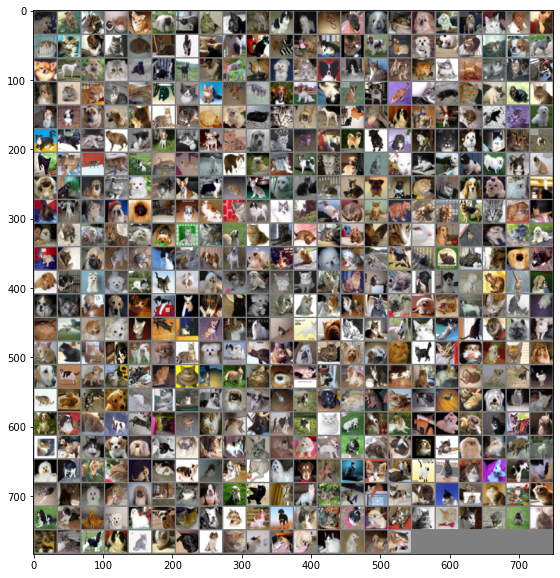

2022-04-16 19:19:39,302 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 10, 'num_workers': 2, 'shuffle': False, 'drop_last': True, 'pin_memory': True}


Image shape:  torch.Size([500, 3, 32, 32])


In [3]:
# get some random training images
dataiter = iter(dataloader)
real_image_examples, classes = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(real_image_examples, nrow=int(np.sqrt(batch_size))))
print("Image shape: ", real_image_examples.size())

test_dataset = torch.utils.data.Subset(dataloader, torch.arange(500))


test_dataloader  = idist.auto_dataloader(
    test_dataset, 
    batch_size=10, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)

In [4]:
dog_real_indexes = np.where(classes == dog_index)
cat_real_indexes = np.where(classes == cat_index)
dog_real = real_image_examples[dog_real_indexes].cpu()
cat_real = real_image_examples[cat_real_indexes].cpu()
latent_dim = 32
height = 32
width = 32
channels = 3
ohe_embedded_dim = 8
n_classes = 2


In [5]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

In [6]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im


______

## Least Squares GAN (Our Vanilla GAN)

In [7]:

class GeneratorVanilla(nn.Module):
    def __init__(self):
        super(GeneratorVanilla, self).__init__()
        
        # Set up the ohe -> FC 256
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, ohe_embedded_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # First, transform the input into a 8x8 256-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + ohe_embedded_dim, 
                      256 * self.init_size ** 2) )
        self.conv_blocks = nn.Sequential(
            #input 256 X init_size X init_size
            nn.BatchNorm2d(256), #8X8
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(128), #16X16
            nn.Conv2d(128, 128, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(128), #16X16
            nn.Conv2d(128, 64, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(64), #16X16
            nn.Conv2d(64, 64, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(64), #16X16
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),#32X32
            
            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(32, channels, kernel_size=3, padding='same'),
            nn.Tanh(),
        )
        
    def forward(self, z, ohe):
        #add the ohe input
        out_ohe = self.ohe_fc(ohe)
        z = torch.cat((z, out_ohe), dim=1)
        
        # expand the sampled z to 8x8
        out = self.l1(z)
        
        out = torch.reshape(out, (out.shape[0], 256, self.init_size, self.init_size))
        
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [8]:
class DiscriminatorVanilla(nn.Module):

    def __init__(self):
        super(DiscriminatorVanilla, self).__init__()
        
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32, 0.8),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), #8X8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
        )
        
        # laten_dim_layer layer
        self.laten_dim_layer = nn.Sequential(nn.Linear(256 * 8 ** 2 + 16, 32), 
                                                  nn.Sigmoid())
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(32 + 16, 1), 
                                                  nn.Sigmoid())
    def forward(self, img, ohe):
        out_ohe = self.ohe_fc(ohe)
        
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        
        # move to the latent dim
        out = torch.cat((out, out_ohe), dim=1)
        out = self.laten_dim_layer(out)
        
        #validate the latent dim
        out = torch.cat((out, out_ohe), dim=1)
        validity = self.classification_layer(out)
        return validity

In [9]:
img = dataiter.next()
img = img[0][100]

generator = GeneratorVanilla()
discriminator = DiscriminatorVanilla()

generator.to(device)
discriminator.to(device)

random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes,1)]))

#Sample random points in the latent space
random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))

In [10]:
generator = GeneratorVanilla()
discriminator = DiscriminatorVanilla()

generator.to(device)
discriminator.to(device)


# LSGAN says they use ADAM, but follow up papers say RMSProp is lsightly better
#lr = 0.0002
#betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),
                                              lr=0.0002, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(),
                                    lr=0.0001, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

DiscriminatorVanilla(
  (ohe_fc): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(128, eps=0.8, momentum=0.

### Set up for evaulating Inception Score

In [17]:
import PIL.Image as Image

from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage
from ignite.metrics import InceptionScore


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        random_latent_vectors = torch.randn(batch_size, latent_dim, device=device)
        random_ohe = Tensor(np.eye(n_classes)[np.random.choice(n_classes, batch_size)])
        
        fake_batch = generator(random_latent_vectors, random_ohe)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real
    
    
# Data for IS Score
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

# Use dataloader as test data, needs to be changed
evaluator = Engine(evaluation_step)
is_metric.attach(evaluator, "is")

is_values = []
def log_training_results(engine):
    evaluator.run(dataloader, max_epochs=1)
    metrics = evaluator.state.metrics
    is_score = metrics['is']
    is_values.append(is_score)
    print(f"*    IS : {is_score:4f}")

### Training the model

In [20]:
log_every = 10
n_classes = 2
score_frequency = 2


# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

class_mappings = {
    3: 0,
    5: 1,
}

def train(generator, gan_optimizer,
          discriminator, discriminator_optimizer,
          iterations, dataloader, begin_step=None
          
    ):
    total_steps = 0
    if begin_step is not None:
        total_steps = begin_step

    for step in range(iterations):
        total_steps = total_steps+1

        for i, (imgs, classes) in enumerate(dataloader):

            # Get the OHE of the imgs we used.
            classes.apply_(lambda c: class_mappings[c])
            ohe = F.one_hot(classes, num_classes=n_classes).to(device)
            ohe = ohe.float()

            #===================================
            # GENERATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            gan_optimizer.zero_grad()

            random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, imgs.shape[0])]))
            # Sample random points in the latent space
            random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
            # Decode them to fake images, through the generator
            generated_images = generator(random_latent_vectors, random_ohe)

            # Assemble labels that say "all real images"
            # misleading target, c=1
            misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

            # Get MSE Loss function
            # want generator output to generate images that are "close" to all "ones" 
            g_loss = adversarial_loss(discriminator(generated_images, random_ohe), misleading_targets)

            # now back propagate to get derivatives
            g_loss.backward()

            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            gan_optimizer.step()

            #===================================
            # DISCRIMINATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            discriminator_optimizer.zero_grad()

            # Combine real images with some generator images
            real_images = Variable(imgs.type(Tensor))
            combined_images = torch.cat([real_images, generated_images.detach()])
            # in the above line, we "detach" the generated images from the generator
            # this is to ensure that no needless gradients are calculated 
            # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
            # but they would be calculated here, which wastes time.

            # Assemble labels discriminating real from fake images
            # real label, a=1 and fake label, b=0
            labels = torch.cat((
                Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
                Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
            ))
            # Add random noise to the labels - important trick!
            labels += 0.05 * torch.rand(labels.shape).to(device)

            # Setup Discriminator loss
            # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
            d_loss = (
                adversarial_loss(discriminator(combined_images[:batch_size], ohe), labels[:batch_size]) + \
                adversarial_loss(discriminator(combined_images[batch_size:], random_ohe), labels[batch_size:])
                ) / 2

            # get gradients according to loss above
            d_loss.backward()
            # optimize the discriminator parameters to better classify images
            discriminator_optimizer.step()

            # Now Clip weights of discriminator (manually)
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            #===================================
        
        # Occasionally save / plot
        if step % log_every == 0:
            # Print metrics
            print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
            # save images in a list for display later
            
            with torch.no_grad():
                fake_output_cats = generator(fixed_random_latent_vectors, fixed_cat_ohe).detach().cpu()
                fake_output_dogs = generator(fixed_random_latent_vectors, fixed_dog_ohe).detach().cpu()
            img_list_cat.append(torchvision.utils.make_grid(fake_output_cats, padding=2, normalize=True, nrow=5))
            img_list_dog.append(torchvision.utils.make_grid(fake_output_dogs, padding=2, normalize=True, nrow=5))

            # in addition, save off a checkpoint of the current models and images
            ims_cat = np.array([np.transpose(np.hstack((i,real_image_numpy_cat)), (2,1,0)) for i in img_list_cat])
            np.save('models/gan_models/ls_images_cat.npy',ims_cat)
            ims_dog = np.array([np.transpose(np.hstack((i,real_image_numpy_dog)), (2,1,0)) for i in img_list_dog])
            np.save('models/gan_models/ls_images_dog.npy',ims_dog)

            # save the state of the models (will need to recreate upon reloading)
            torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
            torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
    return (ims_cat, ims_dog)


In [ ]:
%%time
"""
Train the Vanilla GAN. Here we use the train method above and plot each class seperately
"""
iterations = 1000



# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
fixed_cat_ohe = Tensor(np.eye(n_classes)[np.zeros(plot_num_examples).astype('uint8')]).to(device)
fixed_dog_ohe = Tensor(np.eye(n_classes)[np.zeros(plot_num_examples).astype('uint8') + 1]).to(device)
img_list_cat= []
img_list_dog = []
total_steps = 0

real_image_numpy_cat = np.transpose(
    torchvision.utils.make_grid(cat_real[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))
real_image_numpy_dog = np.transpose(
    torchvision.utils.make_grid(dog_real[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))

ims_cat, ims_dog = train(generator=generator, gan_optimizer=gan_optimizer,
                         discriminator=discriminator, discriminator_optimizer=discriminator_optimizer,
                         iterations=iterations, dataloader=dataloader
                         )


Loss at step 1: D(z_c)=0.23970317840576172, D(G(z_mis))=0.2097332626581192
Loss at step 11: D(z_c)=0.21870927512645721, D(G(z_mis))=0.3299904763698578
Loss at step 21: D(z_c)=0.20145325362682343, D(G(z_mis))=0.2750142812728882
Loss at step 31: D(z_c)=0.20100167393684387, D(G(z_mis))=0.4165138602256775
Loss at step 41: D(z_c)=0.24267078936100006, D(G(z_mis))=0.232106551527977
Loss at step 51: D(z_c)=0.23003238439559937, D(G(z_mis))=0.34719130396842957
Loss at step 61: D(z_c)=0.2322157621383667, D(G(z_mis))=0.20596082508563995
Loss at step 71: D(z_c)=0.22710835933685303, D(G(z_mis))=0.28948548436164856
Loss at step 81: D(z_c)=0.24506410956382751, D(G(z_mis))=0.264983594417572
Loss at step 91: D(z_c)=0.2155238538980484, D(G(z_mis))=0.32814285159111023
Loss at step 101: D(z_c)=0.2334376722574234, D(G(z_mis))=0.2156953513622284
Loss at step 111: D(z_c)=0.22617802023887634, D(G(z_mis))=0.23180420696735382
Loss at step 121: D(z_c)=0.22470757365226746, D(G(z_mis))=0.2227163016796112
Loss at st

In [ ]:


fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims_cat]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims_dog]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

## Evaluate performance

Adapted from https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/#gan-evaluation--the-frechet-inception-distance-and-inception-score-metrics

In [ ]:
log_training_results(evaluator)

_________________________________

## Feature Matching

In order to do feature matching we are also going to add more fully connected layers to our model.
This is not required but to us, it makes it easier to get out a "feature set" from the model

In [7]:
latent_dim = 32
height = 32
width = 32
channels = 3
ohe_embedded_dim = 8
n_classes = 2

class GeneratorFeatureMatching(nn.Module):
    def __init__(self):
        super(GeneratorFeatureMatching, self).__init__()
        
        # Set up the ohe -> FC 256
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, ohe_embedded_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # First, transform the input into a 8x8 256-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.ls = nn.Sequential(
            nn.Linear(latent_dim + ohe_embedded_dim, 
                      128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128 * self.init_size ** 2,
                      256 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv_blocks = nn.Sequential(
            #input 256 X init_size X init_size
            nn.BatchNorm2d(256), #8X8
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(128), #16X16
            nn.Conv2d(128, 128, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(128), #16X16
            nn.Conv2d(128, 64, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(64), #16X16
            nn.Conv2d(64, 64, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(64), #16X16
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),#32X32
            
            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(32, channels, kernel_size=3, padding='same'),
            nn.Tanh(),
        )
        
    def forward(self, z, ohe):
        #add the ohe input
        out_ohe = self.ohe_fc(ohe)
        z = torch.cat((z, out_ohe), dim=1)
        
        # expand the sampled z to 8x8
        out = self.ls(z)
        
        out = torch.reshape(out, (out.shape[0], 256, self.init_size, self.init_size))
        
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [12]:
n_classes


2

In [13]:
class DiscriminatorFeatureMatching(nn.Module):

    def __init__(self):
        super(DiscriminatorFeatureMatching, self).__init__()
        
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32, 0.8),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), #8X8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
        )
        
        
        # The height and width of downsampled image
        #FC layer to create loss
        self.feature_layer = nn.Sequential(
            nn.Linear(256 * 8 ** 2 + 16, 128 * 8 ** 2), nn.LeakyReLU(0.2, inplace=True)
        )
                
        # laten_dim_layer layer
        self.laten_dim_layer = nn.Sequential(nn.Linear(128 * 8 ** 2 + 16, 32), 
                                                  nn.LeakyReLU(0.2))
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(32 + 16, 1), 
                                                  nn.Sigmoid())
        
    def get_features(self, img, ohe):
        """
        This funtion marks the point in the network we will do feature matching on.
        """
        out_ohe = self.ohe_fc(ohe)
        
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        # concat ohe output
        out = torch.cat((out, out_ohe), dim=1)
        out = self.feature_layer(out)
        return out
        
    def forward(self, img, ohe):
        out_ohe = self.ohe_fc(ohe)
        
        out = self.get_features(img, ohe)
        
        out = torch.cat((out, out_ohe), dim=1)
        out = self.laten_dim_layer(out)
        
        out = torch.cat((out, out_ohe), dim=1)
        validity = self.classification_layer(out)
        return validity

In [14]:
log_every = 10
n_classes = 2


# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)
def train_feature_matching(generator, gan_optimizer,
          discriminator, discriminator_optimizer,
          iterations, dataloader, begin_step=None
          
    ):
    total_steps = 0
    if begin_step is not None:
        total_steps = begin_step

    for step in range(iterations):
        total_steps = total_steps+1

        for i, (imgs, classes) in enumerate(dataloader):

            # Get the OHE of the imgs we used.
            classes.apply_(lambda c: 0 if c == 3 else 1)
            ohe = F.one_hot(classes, num_classes=n_classes).to(device)
            ohe = ohe.float()

            #===================================
            # GENERATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            gan_optimizer.zero_grad()

            random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, imgs.shape[0])]))
            # Sample random points in the latent space
            random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
            # Decode them to fake images, through the generator
            generated_images = generator(random_latent_vectors, random_ohe)
            
            # Combine real images with some generator images
            real_images = Variable(imgs.type(Tensor))
            combined_images = torch.cat([real_images, generated_images.detach()])
            # in the above line, we "detach" the generated images from the generator
            # this is to ensure that no needless gradients are calculated 
            # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
            # but they would be calculated here, which wastes time.

            # Assemble labels that say "all real images"
            # misleading target, c=1
            misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

            #OLD WAY
            # Get MSE Loss function
            # want generator output to generate images that are "close" to all "ones" 
            #g_loss = adversarial_loss(discriminator(generated_images, random_ohe), misleading_targets) / 2
            
            # Add feature macthing <<<<< THIS IS WHERE THIS ONE CHAGNES
            fake_features = torch.mean(discriminator.get_features(generated_images, random_ohe), dim=0)
            real_features = torch.mean(discriminator.get_features(real_images, ohe), dim=0)
            g_loss = torch.mean(torch.square(fake_features-real_features)) / 2

            # now back propagate to get derivatives
            g_loss.backward()

            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            gan_optimizer.step()

            #===================================
            # DISCRIMINATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            discriminator_optimizer.zero_grad()

            # Assemble labels discriminating real from fake images
            # real label, a=1 and fake label, b=0
            labels = torch.cat((
                Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
                Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
            ))
            # Add random noise to the labels - important trick!
            labels += 0.05 * torch.rand(labels.shape).to(device)

            # Setup Discriminator loss
            # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
            d_loss = (
                adversarial_loss(discriminator(combined_images[:batch_size], ohe), labels[:batch_size]) + \
                adversarial_loss(discriminator(combined_images[batch_size:], random_ohe), labels[batch_size:])
                ) / 2

            # get gradients according to loss above
            d_loss.backward()
            # optimize the discriminator parameters to better classify images
            discriminator_optimizer.step()

            # Now Clip weights of discriminator (manually)
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            #===================================

        # Occasionally save / plot
        if step % log_every == 0:
            # Print metrics
            print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
            # save images in a list for display later
            
            with torch.no_grad():
                fake_output_cats = generator(fixed_random_latent_vectors, fixed_cat_ohe).detach().cpu()
                fake_output_dogs = generator(fixed_random_latent_vectors, fixed_dog_ohe).detach().cpu()
            img_list_cat.append(torchvision.utils.make_grid(fake_output_cats, padding=2, normalize=True, nrow=5))
            img_list_dog.append(torchvision.utils.make_grid(fake_output_dogs, padding=2, normalize=True, nrow=5))

            # in addition, save off a checkpoint of the current models and images
            ims_cat = np.array([np.transpose(np.hstack((i,real_image_numpy_cat)), (2,1,0)) for i in img_list_cat])
            np.save('models/gan_models/ls_images_cat.npy',ims_cat)
            ims_dog = np.array([np.transpose(np.hstack((i,real_image_numpy_dog)), (2,1,0)) for i in img_list_dog])
            np.save('models/gan_models/ls_images_dog.npy',ims_dog)

            # save the state of the models (will need to recreate upon reloading)
            torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/feature_matching_gen.pth')
            torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/feature_matching_dis.pth')
    return (ims_cat, ims_dog)


In [15]:
generator = GeneratorFeatureMatching()
discriminator = DiscriminatorFeatureMatching()

generator.to(device)
discriminator.to(device)


# LSGAN says they use ADAM, but follow up papers say RMSProp is lsightly better
#lr = 0.0002
#betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),
                                              lr=0.0002, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(),
                                    lr=0.0001, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

DiscriminatorFeatureMatching(
  (ohe_fc): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(128, eps=0.8, mom

In [17]:
%%time
"""
Train the Feature Matching GAN. Here we use the train method above and plot each class seperately
"""
iterations = 10
batch_size = 500

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
fixed_cat_ohe = Tensor(np.eye(n_classes)[np.zeros(plot_num_examples).astype('uint8')]).to(device)
fixed_dog_ohe = Tensor(np.eye(n_classes)[np.zeros(plot_num_examples).astype('uint8') + 1]).to(device)
img_list_cat= []
img_list_dog = []
total_steps = 0

real_image_numpy_cat = np.transpose(
    torchvision.utils.make_grid(cat_real[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))
real_image_numpy_dog = np.transpose(
    torchvision.utils.make_grid(dog_real[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))


dataloader = torch.utils.data.DataLoader(frog_dog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

ims_cat, ims_dog = train_feature_matching(generator=generator, gan_optimizer=gan_optimizer,
                         discriminator=discriminator, discriminator_optimizer=discriminator_optimizer,
                         iterations=iterations, dataloader=dataloader
                         )

Loss at step 1: D(z_c)=0.3431498408317566, D(G(z_mis))=0.047684840857982635
CPU times: user 1min 44s, sys: 1.74 s, total: 1min 46s
Wall time: 1min 45s


In [ ]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims_cat]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims_dog]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

__________

## Virtual Batch Normalization

Instead of using Batch Nromalization, we are going to use Virtual Batch Normalization. Instead of using the generated data to normalize, using learned parameters, save off a reference set that we will use to normalize.

We are going to use the implementation from torchgan. From what we can tell the way it works it the stats are saved off from the first call, and from there you can clear it by passing clear=True to forward. So we will run the first forward through 

In [7]:
log_every = 10
n_classes = 2


# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# This will only differ by saving off the first batch as x_ref
def train_batch_norm(generator, gan_optimizer,
                     discriminator, discriminator_optimizer,
                     iterations, dataloader, begin_step=None,
                     reset_statistics=50
          
    ):
    total_steps = 0
    if begin_step is not None:
        total_steps = begin_step

    x_ref = None
    for step in range(iterations):
        total_steps = total_steps+1

        for i, (imgs, classes) in enumerate(dataloader):

            # Save off x_ref
            if step % reset_statistics == 0:
                #We need to set the statistics 
                #First we need the latent dim for the generator with real images
                real_images = Variable(imgs.type(Tensor))
                classes.apply_(lambda c: 0 if c == 3 else 1)
                ohe = F.one_hot(classes, num_classes=n_classes).to(device)
                ohe = ohe.float()
                features = discriminator.get_features(real_images, ohe).detach()
                
                #pass this set of real data through the generator and set to set the statistics
                generator(features, ohe).detach()
                
                #Now the various places where the statistics are used are set we should zero out the 
                #grad just to be safe
                generator.zero_grad()
                next
            
            # Get the OHE of the imgs we used.
            classes.apply_(lambda c: 0 if c == 3 else 1)
            ohe = F.one_hot(classes, num_classes=n_classes).to(device)
            ohe = ohe.float()

            #===================================
            # GENERATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            gan_optimizer.zero_grad()

            random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, imgs.shape[0])]))
            # Sample random points in the latent space
            random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
            # Decode them to fake images, through the generator
            generated_images = generator(random_latent_vectors, random_ohe)
            
            # Combine real images with some generator images
            real_images = Variable(imgs.type(Tensor))
            combined_images = torch.cat([real_images, generated_images.detach()])
            # in the above line, we "detach" the generated images from the generator
            # this is to ensure that no needless gradients are calculated 
            # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
            # but they would be calculated here, which wastes time.

            # Assemble labels that say "all real images"
            # misleading target, c=1
            misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

            #OLD WAY
            # Get MSE Loss function
            # want generator output to generate images that are "close" to all "ones" 
            #g_loss = adversarial_loss(discriminator(generated_images, random_ohe), misleading_targets) / 2
            
            # Add feature macthing <<<<< THIS IS WHERE THIS ONE CHAGNES
            fake_features = torch.mean(discriminator.get_features(generated_images, random_ohe), dim=0)
            real_features = torch.mean(discriminator.get_features(real_images, ohe), dim=0)
            g_loss = torch.mean(torch.square(fake_features-real_features)) / 2

            # now back propagate to get derivatives
            g_loss.backward()

            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            gan_optimizer.step()

            #===================================
            # DISCRIMINATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            discriminator_optimizer.zero_grad()

            # Assemble labels discriminating real from fake images
            # real label, a=1 and fake label, b=0
            labels = torch.cat((
                Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
                Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
            ))
            # Add random noise to the labels - important trick!
            labels += 0.05 * torch.rand(labels.shape).to(device)

            # Setup Discriminator loss
            # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
            d_loss = (
                adversarial_loss(discriminator(combined_images[:batch_size], ohe), labels[:batch_size]) + \
                adversarial_loss(discriminator(combined_images[batch_size:], random_ohe), labels[batch_size:])
                ) / 2

            # get gradients according to loss above
            d_loss.backward()
            # optimize the discriminator parameters to better classify images
            discriminator_optimizer.step()

            # Now Clip weights of discriminator (manually)
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            #===================================

        # Occasionally save / plot
        if step % log_every == 0:
            # Print metrics
            print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
            # save images in a list for display later
            
            with torch.no_grad():
                fake_output_cats = generator(fixed_random_latent_vectors, fixed_cat_ohe).detach().cpu()
                fake_output_dogs = generator(fixed_random_latent_vectors, fixed_dog_ohe).detach().cpu()
            img_list_cat.append(torchvision.utils.make_grid(fake_output_cats, padding=2, normalize=True, nrow=5))
            img_list_dog.append(torchvision.utils.make_grid(fake_output_dogs, padding=2, normalize=True, nrow=5))

            # in addition, save off a checkpoint of the current models and images
            ims_cat = np.array([np.transpose(np.hstack((i,real_image_numpy_cat)), (2,1,0)) for i in img_list_cat])
            np.save('models/gan_models/ls_images_cat.npy',ims_cat)
            ims_dog = np.array([np.transpose(np.hstack((i,real_image_numpy_dog)), (2,1,0)) for i in img_list_dog])
            np.save('models/gan_models/ls_images_dog.npy',ims_dog)

            # save the state of the models (will need to recreate upon reloading)
            torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/virt_batch_gen.pth')
            torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/virt_batch_dis.pth')
    return (ims_cat, ims_dog)


In [13]:
latent_dim = 32
height = 32
width = 32
channels = 3
ohe_embedded_dim = 8
n_classes = 2

class GeneratorVirtualBatchNorm(nn.Module):
    def __init__(self):
        super(GeneratorVirtualBatchNorm, self).__init__()
        
        # Set up the ohe -> FC 256
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, ohe_embedded_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # First, transform the input into a 8x8 256-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.ls = nn.Sequential(
            nn.Linear(latent_dim + ohe_embedded_dim, 
                      128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128 * self.init_size ** 2,
                      256 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv_blocks = nn.Sequential(
            #input 256 X init_size X init_size
            #nn.BatchNorm2d(256), #8X8
            torchgan.layers.VirtualBatchNorm(256),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(128), #16X16
            nn.Conv2d(128, 128, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(128), #16X16
            nn.Conv2d(128, 64, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(64), #16X16
            nn.Conv2d(64, 64, 3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),#16X16
            
            nn.BatchNorm2d(64), #16X16
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),#32X32
            
            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(32, channels, kernel_size=3, padding='same'),
            nn.Tanh(),
        )
        
    def forward(self, z, ohe):
        #add the ohe input
        out_ohe = self.ohe_fc(ohe)
        z = torch.cat((z, out_ohe), dim=1)
        
        # expand the sampled z to 8x8
        out = self.ls(z)
        
        out = torch.reshape(out, (out.shape[0], 256, self.init_size, self.init_size))
        
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [14]:
class DiscriminatorFeatureMatching(nn.Module):

    def __init__(self):
        super(DiscriminatorFeatureMatching, self).__init__()
        
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32, 0.8),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), #8X8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
        )
        
        
        # The height and width of downsampled image
        ds_size = width // 2 ** 4  
        #FC layer to create loss
        self.feature_layer = nn.Sequential(
            nn.Linear(256 * 8 ** 2 + 16, 128 * 8 ** 2), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128 * 8 ** 2,32), nn.Sigmoid()
        )
        
        # Classification layer 
        self.classification_layer = nn.Sequential(
            nn.Linear(32 + 16,1), nn.Sigmoid()
        )
        
    def get_features(self, img, ohe):
        """
        This funtion marks the point in the network we will do feature matching on.
        """
        out_ohe = self.ohe_fc(ohe)
        
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        # concat ohe output
        out = torch.cat((out, out_ohe), dim=1)
        out = self.feature_layer(out)
        return out
    
    def forward(self, img, ohe):
        out = self.get_features(img, ohe)
        
        out_ohe = self.ohe_fc(ohe)
        out = torch.cat((out, out_ohe), dim=1)
        validity = self.classification_layer(out)
        
        return validity

In [15]:
# Changed to handle Virtural Batch Norm
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    if classname.find('VirtualBatchNorm') == 0:
        m.scale.data.normal_(1.0, 0.2)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') == 0:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

In [16]:
generator = GeneratorVirtualBatchNorm()
discriminator = DiscriminatorFeatureMatching()

generator.to(device)
discriminator.to(device)


# LSGAN says they use ADAM, but follow up papers say RMSProp is lsightly better
#lr = 0.0002
#betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),
                                              lr=0.0002, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(),
                                    lr=0.0001, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 


discriminator.apply(weights_init)
generator.apply(weights_init)

GeneratorVirtualBatchNorm(
  (ohe_fc): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (ls): Sequential(
    (0): Linear(in_features=40, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=8192, out_features=16384, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_blocks): Sequential(
    (0): VirtualBatchNorm()
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [17]:
%%time
"""
Train the Feature Matching GAN. Here we use the train method above and plot each class seperately
"""
iterations = 10
batch_size = 500

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
fixed_cat_ohe = Tensor(np.eye(n_classes)[np.zeros(plot_num_examples).astype('uint8')]).to(device)
fixed_dog_ohe = Tensor(np.eye(n_classes)[np.zeros(plot_num_examples).astype('uint8') + 1]).to(device)
img_list_cat= []
img_list_dog = []
total_steps = 0

real_image_numpy_cat = np.transpose(
    torchvision.utils.make_grid(cat_real[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))
real_image_numpy_dog = np.transpose(
    torchvision.utils.make_grid(dog_real[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))


dataloader = torch.utils.data.DataLoader(frog_dog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

ims_cat, ims_dog = train_batch_norm(generator=generator, gan_optimizer=gan_optimizer,
                         discriminator=discriminator, discriminator_optimizer=discriminator_optimizer,
                         iterations=iterations, dataloader=dataloader
                         )

Loss at step 1: D(z_c)=0.2244805544614792, D(G(z_mis))=0.04523176699876785
CPU times: user 1min 45s, sys: 1.75 s, total: 1min 47s
Wall time: 1min 46s
